## 📙 SET THE NAME AND MAIN PARAMETERS

In [1]:
enable_mixed_precision = True

verbose = True

## ⚙️ Import Libraries

In [2]:
import numpy as np

import tensorflow as tf
import keras as tfk
from keras import mixed_precision
from keras.mixed_precision import LossScaleOptimizer
from keras import layers as tfkl
from keras.utils import to_categorical
from keras.layers import Dense
from keras.models import Model
from keras.applications import ConvNeXtTiny, VGG16, VGG19 # Add more
import keras_cv

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt

from datetime import datetime

from tqdm import tqdm

import math

In [3]:
print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

Tensorflow version -> 2.16.1
Keras version -> 3.3.3


In [4]:
# Set the keras global policy to mixed precision
if enable_mixed_precision:
    mixed_precision.set_global_policy('mixed_float16')
    print(mixed_precision.global_policy())

<FloatDTypePolicy "mixed_float16">


In [5]:
# Set random seed
seed = 42
np.random.seed(42)
tf.random.set_seed(42)

## ⏳ Load the Data

In [6]:
# Load data
data = np.load("/kaggle/input/hbntlualk-khahzla-zwspa/augmented_split_dataset.npz")

In [7]:
print(data.keys())

KeysView(NpzFile '/kaggle/input/hbntlualk-khahzla-zwspa/augmented_split_dataset.npz' with keys: X_train, X_test, y_train, y_test)


In [8]:
X_test = data['X_test']
y_test = data['y_test']

In [9]:
print(X_test.shape, y_test.shape)

(1793, 96, 96, 3) (1793, 8)


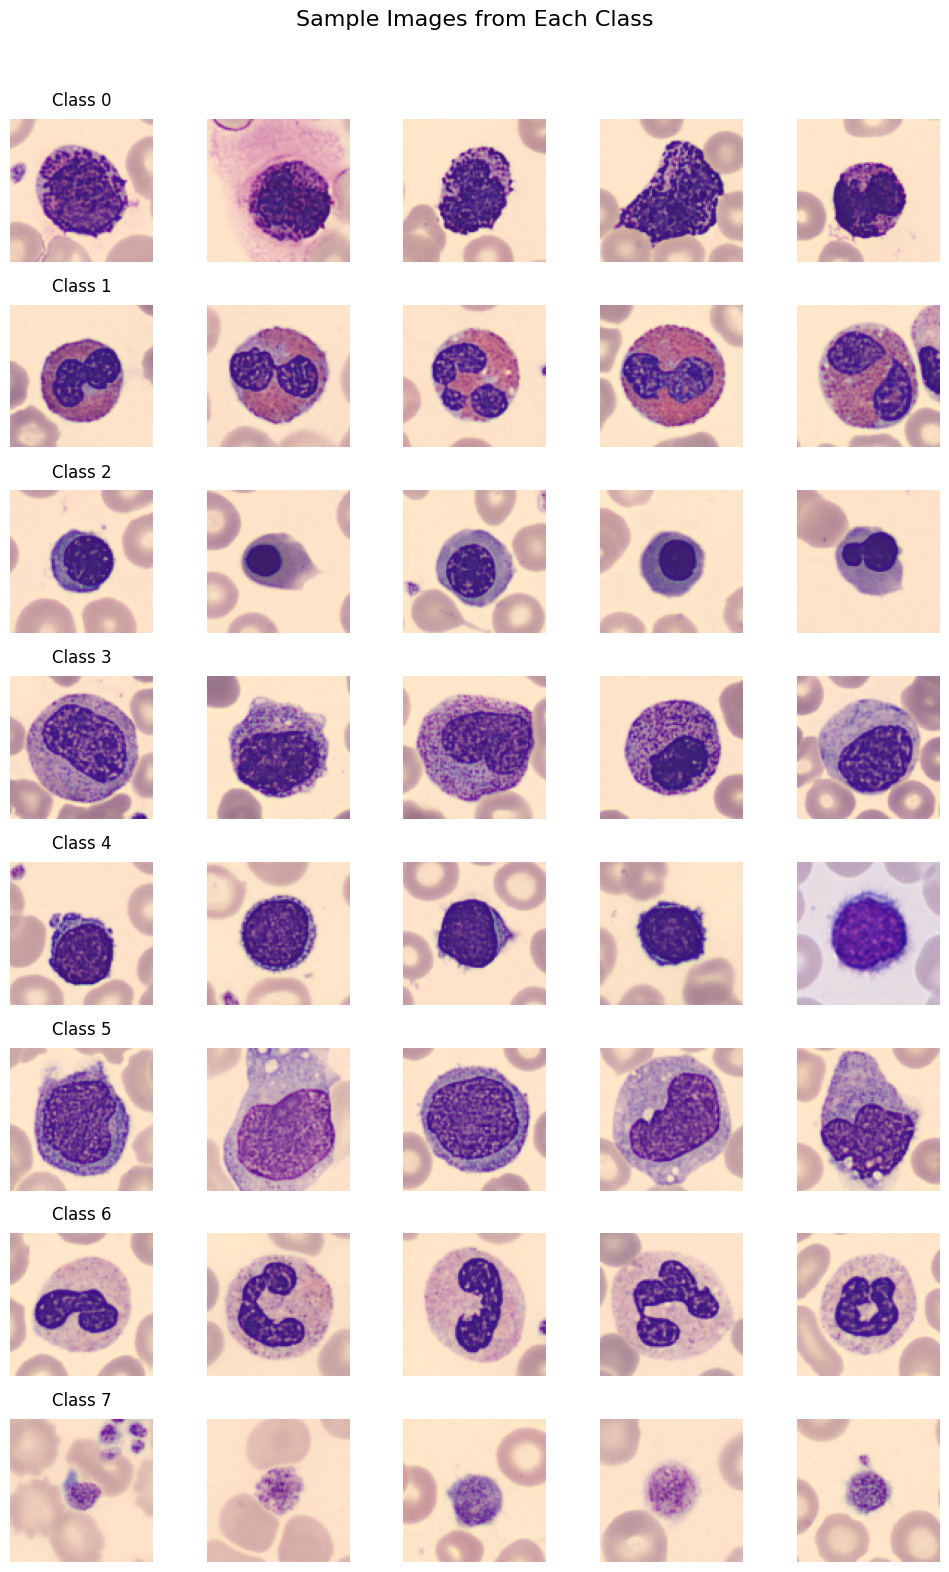

In [10]:
# Number of samples to display per class
samples_per_class = 5
unique_classes = range(y_test.shape[1])  # Assuming classes are labeled from 0 to n-1

# Adjust figure size and remove extra spacing between plots
fig, axes = plt.subplots(len(unique_classes), samples_per_class, figsize=(samples_per_class * 2, len(unique_classes) * 2))
fig.suptitle("Sample Images from Each Class", fontsize=16)

for class_idx in unique_classes:
    # Find indices of samples for this class
    class_indices = np.where(np.argmax(y_test, axis=1) == class_idx)[0]
    # Randomly select images from this class
    selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)

    for i, idx in enumerate(selected_indices):
        ax = axes[class_idx, i]
        ax.imshow(X_test[idx].astype("uint8"))  # Convert to uint8 if needed for display
        ax.axis("off")
        if i == 0:
            ax.set_title(f"Class {class_idx}", fontsize=12, pad=10)  # Add padding to title    

# Adjust layout to reduce spacing
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

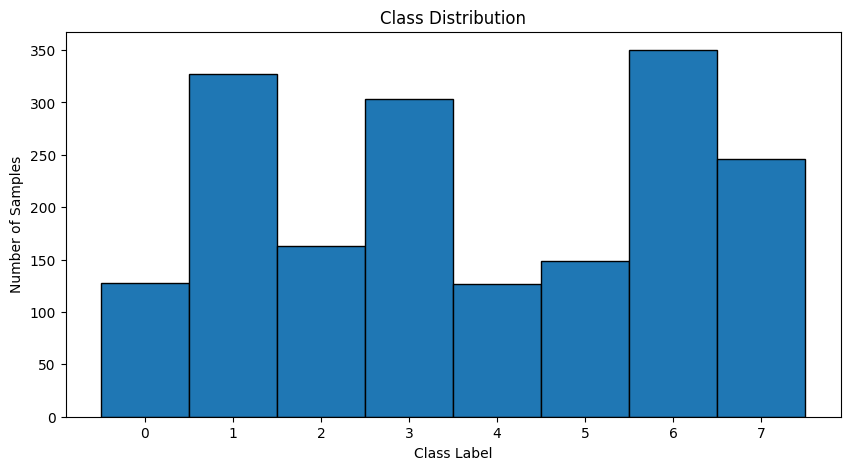

In [11]:
if verbose:
    class_labels = np.argmax(y_test, axis=-1)
    plt.figure(figsize=(10, 5))  # Adjust figure size if needed
    plt.hist(class_labels, bins=np.arange(9) - 0.5, edgecolor='black')
    plt.xlabel('Class Label')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.xticks(np.arange(8))  # Set x-axis ticks to represent class labels
    plt.show()

In [12]:
# Ottieni la policy standard di RandAugment
policy_layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 255),
    magnitude=0.30,
    magnitude_stddev=0.3,
)

#layer da rimuovere da policy
layers_to_remove = (
    keras_cv.layers.RandomContrast,
    keras_cv.layers.RandomColorDegeneration,
    keras_cv.layers.RandomBrightness
)

filtered_layers = [
    layer for layer in policy_layers
    if not isinstance(layer, layers_to_remove)
]

all_layers = filtered_layers


#Definisci la pipeline completa di augmentazione
augmentation = tf.keras.Sequential([
    keras_cv.layers.RandomAugmentationPipeline(
        layers = all_layers,
        augmentations_per_image=3,  # Numero di trasformazioni da applicare per immagine
        rate=1.0  # Probabilità di applicare ciascuna trasformazione
    ),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(1),
    tf.keras.layers.RandomContrast(0.65),
    tf.keras.layers.RandomBrightness(0.50)
    #keras_cv.layers.RandomColorDegeneration(factor=0.1),
], name='Augmentation')

In [13]:
from keras.models import load_model

myModel = load_model('/kaggle/input/vgg_augmenteddata/keras/default/1/model.keras')

I0000 00:00:1732041895.327559      99 service.cc:145] XLA service 0x7eadf0004f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732041895.327615      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


15/57 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

I0000 00:00:1732041899.034486      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step
Predictions Shape: (1793, 8)
Accuracy score over the test set: 0.976
Precision score over the test set: 0.9769
Recall score over the test set: 0.976
F1 score over the test set: 0.9762


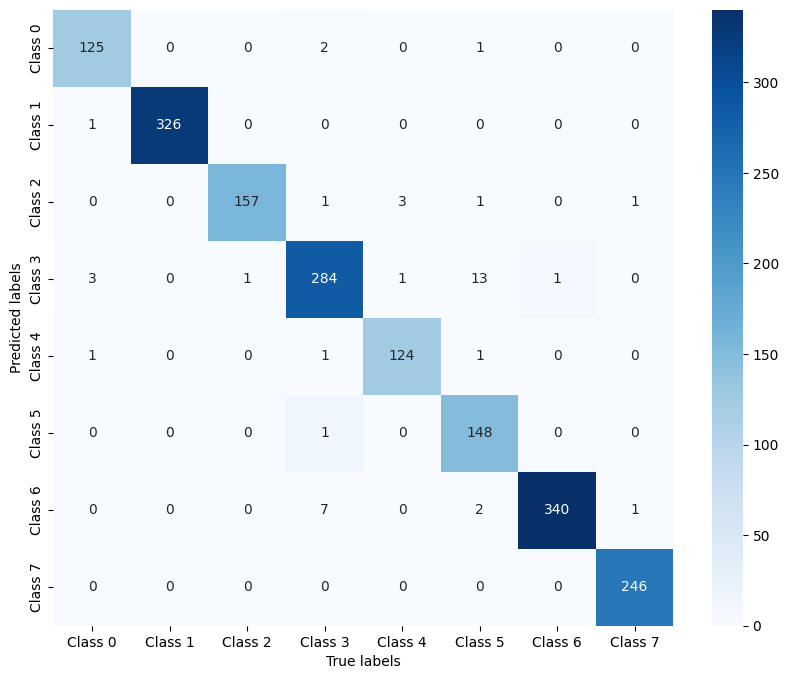

In [14]:
# Predict labels for the entire test set
predictions = myModel.predict(X_test)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Convert predictions to class label
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')   

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)
labels = {i: f"Class {i}" for i in range(cm.shape[0])}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

100%|██████████| 57/57 [15:36<00:00, 16.44s/it]


Predictions Shape: (1793, 8)
Accuracy score over the test set: 0.9554
Precision score over the test set: 0.9587
Recall score over the test set: 0.9554
F1 score over the test set: 0.9555


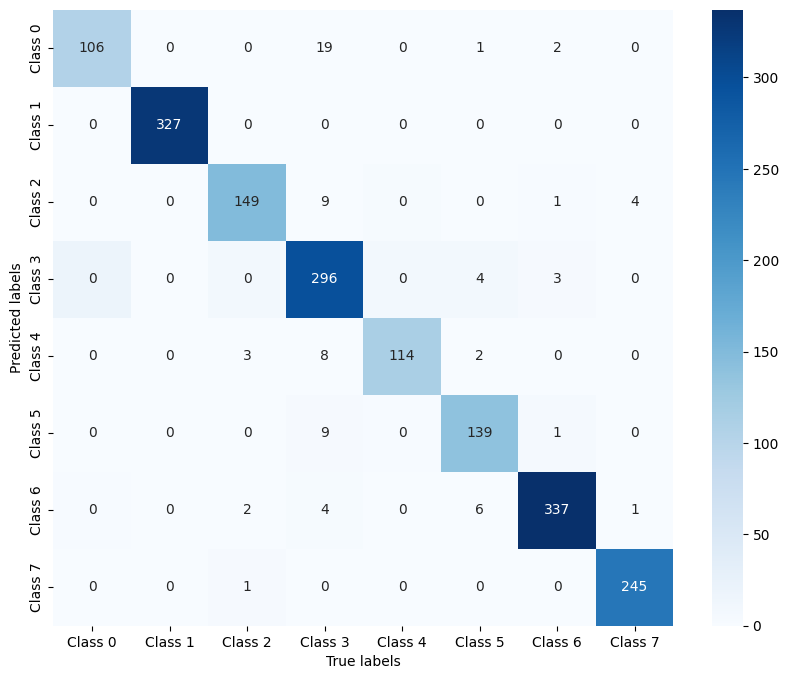

In [15]:
def predict_tta(model, X_test, num_augmentations=10, batch_size=32):
   # Placeholder for aggregated predictions
    all_predictions = []

    # Loop through test images in batches
    num_batches = int(np.ceil(len(X_test) / batch_size))
    for batch_idx in tqdm(range(num_batches)):
        # Extract the current batch
        batch_start = batch_idx * batch_size
        batch_end = min((batch_idx + 1) * batch_size, len(X_test))
        batch = X_test[batch_start:batch_end]
        
        # Expand batch to include augmentation dimension
        batch_augmented = tf.repeat(batch, repeats=num_augmentations, axis=0)
        
        # Apply augmentation to the entire batch
        augmented_batch = augmentation(batch_augmented, training=True)
        
        # Predict on the augmented batch
        preds_augmented = model.predict(augmented_batch, verbose=0, batch_size=batch_size)
        
        # Reshape predictions: [num_images, num_augmentations, num_classes]
        num_classes = preds_augmented.shape[-1]
        preds_reshaped = preds_augmented.reshape(len(batch), num_augmentations, num_classes)
        
        # Aggregate predictions (e.g., average probabilities)
        aggregated_preds = np.mean(preds_reshaped, axis=1)
        all_predictions.append(aggregated_preds)
    
    # Concatenate all batch predictions
    final_predictions = np.vstack(all_predictions)
    return final_predictions

# Predict labels for the entire test set
predictions = predict_tta(myModel, X_test)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Convert predictions to class label
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')   

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)
labels = {i: f"Class {i}" for i in range(cm.shape[0])}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()